In [3]:
#!pip install matplotlib wordcloud

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### READING ANIMELIST.CSV

In [9]:
import os

In [10]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [11]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [12]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [13]:
len(rating_df)

5000000

#### DATA PROCESSING

In [18]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [19]:
len(rating_df)

3246641

In [23]:
min_rating =min(rating_df["rating"])

In [24]:
max_rating =max(rating_df["rating"])

In [25]:
max_rating

10

In [26]:
avg_rating =np.mean(rating_df["rating"])

In [27]:
avg_rating

np.float64(4.122732695114736)

In [28]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [29]:
rating_df.duplicated().sum()

np.int64(0)

In [30]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [31]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [32]:
n_users = len(user2user_encoded)

In [33]:
n_users

4203

In [135]:
## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded

In [34]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [35]:
n_anime = len(anime2anime_encoded)

In [36]:
n_anime

17149

In [37]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [38]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [39]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [40]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [41]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [42]:
len(X_train)

3245641

In [43]:
len(X_test)

1000

In [45]:
type(X_train)

numpy.ndarray

In [46]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [47]:
type(X_test_array)

list

In [48]:
type(X_test_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [49]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [50]:
model = RecommenderNet()

In [52]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [56]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [57]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [58]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [59]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.7934 - mae: 0.3809 - mse: 0.1951 - val_loss: 0.7119 - val_mae: 0.3641 - val_mse: 0.1646 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.7900 - mae: 0.3796 - mse: 0.1937 - val_loss: 0.7738 - val_mae: 0.3776 - val_mse: 0.1889 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.7842 - mae: 0.3775 - mse: 0.1914 - val_loss: 0.7835 - val_mae: 0.3795 - val_mse: 0.1920 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.7759 - mae: 0.3743 - mse: 0.1881 - val_loss: 0.7801 - val_mae: 0.3784 - val_mse: 0.1907 - learning_rate: 3.4000e-05


In [60]:
model.load_weights(checkpoint_filepath)

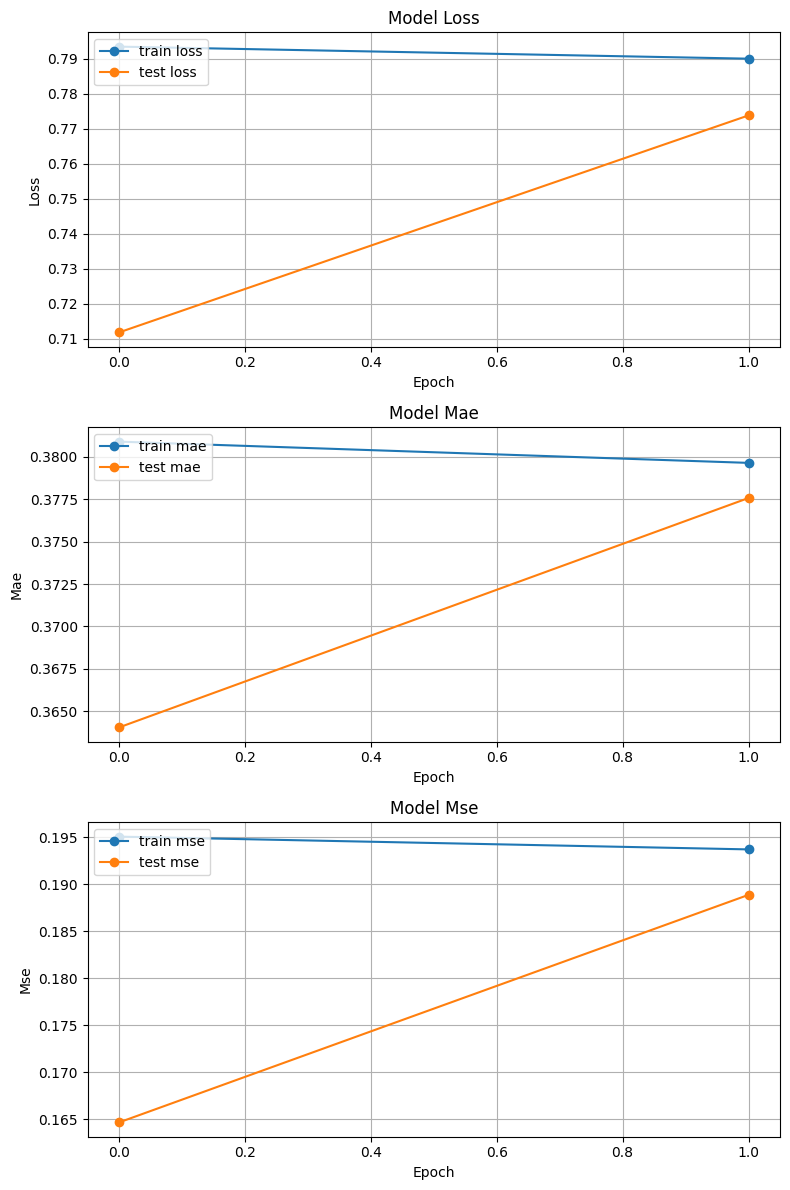

In [61]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [62]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [64]:
anime_weights = extract_weights("anime_embedding",model)

In [65]:
user_weights = extract_weights("user_embedding",model)

#### READING ANIME.CSV

In [66]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [71]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [67]:
df = df.replace("Unknown",np.nan)

In [68]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [69]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [70]:
getAnimeName(6702)

'Fairy Tail'

In [76]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [77]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [78]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [79]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [80]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]
    

In [81]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [82]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV 

In [83]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [84]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [86]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [261]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [87]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [88]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [89]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [90]:
pd.set_option("max_colwidth",None)

In [91]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [92]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Military! Special,0.315730,"Military, Comedy, Ecchi"
8,Osomatsu-kun (1988): Appare! Chibita no Onitaiji zansu,0.301951,Comedy
7,Lupin VIII,0.299518,"Adventure, Comedy, Shounen"
6,Le Cirque de Karakuri,0.298101,"Action, Adventure, Mystery, Drama, Shounen"
5,Shattered Angels,0.284409,"Drama, Magic, Romance, Shounen"
4,Shining Hearts: Shiawase no Pan,0.280799,"Action, Fantasy"
3,Kobo-chan Special (1994),0.279923,"Comedy, Kids, School, Slice of Life"
2,Marin X,0.279909,"Action, Adventure, Mecha, Sci-Fi, Shounen"
1,Washimo 4th Season,0.279562,"Sci-Fi, Slice of Life, Comedy, Kids, School"
0,Youkai Watch: Shadow Side,0.278834,"Comedy, Demons, Kids, Supernatural"


### USER BASED RECOMMENDATION

In [93]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [94]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,12171,0.332975
8,8557,0.285064
7,13470,0.281360
6,11064,0.280154
5,16355,0.277211
4,5455,0.262667
3,15611,0.262207
2,15720,0.261534
1,2400,0.260860
0,12218,0.255058


In [95]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [96]:
from collections import defaultdict

In [97]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [98]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [99]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [100]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




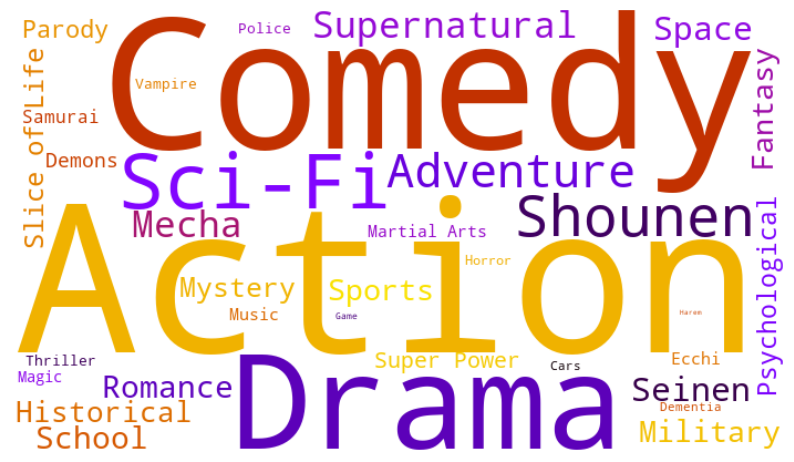

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [101]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [102]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [103]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [104]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [105]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,11,Little Witch Academia,"Adventure, Comedy, Fantasy, Magic, School","""A believing heart is your magic!""—these were the words that Atsuko ""Akko"" Kagari's idol, the renowned witch Shiny Chariot, said to her during a magic performance years ago. Since then, Akko has lived by these words and aspired to be a witch just like Shiny Chariot, one that can make people smile. Hence, even her non-magical background does not stop her from enrolling in Luna Nova Magical Academy. However, when an excited Akko finally sets off to her new school, the trip there is anything but smooth. After her perilous journey, she befriends the shy Lotte Yansson and the sarcastic Sucy Manbavaran. To her utmost delight, she also discovers Chariot's wand, the Shiny Rod, which she takes as her own. Unfortunately, her time at Luna Nova will prove to more challenging than Akko could ever believe. She absolutely refuses to stay inferior to the rest of her peers, especially to her self-proclaimed rival, the beautiful and gifted Diana Cavendish, so she relies on her determination to compensate for her reckless behavior and ineptitude in magic. In a time when wizardry is on the decline, Little Witch Academia follows the magical escapades of Akko and her friends as they learn the true meaning of being a witch."


### HYBRID RECOMMENDER SYSTEM

In [319]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [320]:
hybrid_recommendation(11880)

['Death Note', 'Angel Beats!', 'Clannad', 'The Girl Who Leapt Through Time', 'Code Geass:Lelouch of the Rebellion R2', 'Clannad ~After Story~', 'Hotarubi no Mori e', 'Nisemonogatari', 'No Game No Life: Zero', 'A Silent Voice']


['Death Note',
 'Angel Beats!',
 'Clannad',
 'The Girl Who Leapt Through Time',
 'Code Geass:Lelouch of the Rebellion R2',
 'Clannad ~After Story~',
 'Hotarubi no Mori e',
 'Nisemonogatari',
 'No Game No Life: Zero',
 'A Silent Voice']